**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Listeria-infected vs uninfected matched explants (day1) single cell

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
anndata <- readRDS('../../../data_integration/results/scVI/listeria_singleCell_24h.rds')
anndata

An object of class Seurat 
36601 features across 30835 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$cell_type

In [4]:
head(Idents(anndata))

Pla_HDBR12330712_AAACCCAAGTCGTTAC Pla_HDBR12330712_AAACCCACAACCGTAT 
                       VCT_fusing                               VCT 
Pla_HDBR12330712_AAACCCAGTATGCTTG Pla_HDBR12330712_AAACCCAGTCGCAACC 
                               PV                               HBC 
Pla_HDBR12330712_AAACCCAGTGAACGGT Pla_HDBR12330712_AAACGAAAGATGGTCG 
                            PAMM1                              iEVT 
15 Levels: EVT_1 EVT_2 Endo_f F F_p F_sm HBC HBC_p PAMM1 PV VCT ... iEVT

# Macrophages

In [5]:
Mos= subset(x = anndata, idents = c("HBC","PAMM1"))

Idents(object = Mos) <- "infection"


#fixxing levels
Mos$celltype.Stage = factor(Mos$celltype.Stage, levels = c("HBC-Lm_24h", "HBC-UI_Lm_24h", "PAMM1-Lm_24h","PAMM1-UI_Lm_24h"))
Mos$cell_type<- factor(Mos$cell_type, levels = c("HBC","PAMM1"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
Mos$infection<- factor(Mos$infection, levels = c("UI","Lm"))

In [6]:
Mos$classification = paste(Mos$cell_type, Mos$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = Mos, features = rownames(Mos), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [7]:
head(percent_mat)

,HBC-Lm,HBC-UI,PAMM1-Lm,PAMM1-UI
DPP6,2.518454,3.949731,1.835664,1.756312
LINC02665,0.000000,0.000000,0.000000,0.000000
ITCH-IT1,0.000000,0.000000,0.000000,0.000000
AC100782.1,0.000000,0.000000,0.000000,0.000000
COG4,13.634390,22.800718,9.877622,15.477497
FDXR,4.429006,8.138839,1.486014,3.073546


In [8]:
#print(Idents(VCT_fusing))

In [9]:
table(Mos[["celltype.Stage"]] )


     HBC-Lm_24h   HBC-UI_Lm_24h    PAMM1-Lm_24h PAMM1-UI_Lm_24h 
           4606            3342            1144             911 

In [10]:
anndata_sce <- as.SingleCellExperiment(Mos)

In [11]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 10003 
metadata(0):
assays(2): counts logcounts
rownames(36601): DPP6 LINC02665 ... AL357054.2 SDK2
rowData names(0):
colnames(10003): Pla_HDBR12330712_AAACCCAGTCGCAACC
  Pla_HDBR12330712_AAACCCAGTGAACGGT ...
  Pla_HDBR13661572_TTTGTTGAGGTTCATC Pla_HDBR13661572_TTTGTTGGTGGTAACG
colData names(12): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [12]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Lm-HBC-Hrv135-1,Lm-HBC-Hrv135-2,Lm-HBC-Hrv135-3,Lm-HBC-Hrv136-1,Lm-HBC-Hrv136-2,Lm-HBC-Hrv136-3,Lm-HBC-Hrv236-1,Lm-HBC-Hrv236-2,Lm-HBC-Hrv236-3,Lm-PAMM1-Hrv135-1,⋯,UI-HBC-Hrv236-3,UI-PAMM1-Hrv135-1,UI-PAMM1-Hrv135-2,UI-PAMM1-Hrv135-3,UI-PAMM1-Hrv136-1,UI-PAMM1-Hrv136-2,UI-PAMM1-Hrv136-3,UI-PAMM1-Hrv236-1,UI-PAMM1-Hrv236-2,UI-PAMM1-Hrv236-3
DPP6,9,4,6,32,46,12,13,35,19,0,⋯,25,2,1,2,2,1,2,3,3,2
LINC02665,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ITCH-IT1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0



  HBC-Lm   HBC-UI PAMM1-Lm PAMM1-UI 
       9        9        9        9 


UI Lm 
18 18 

In [13]:
summed

class: SingleCellExperiment 
dim: 36601 36 
metadata(0):
assays(1): counts
rownames(36601): DPP6 LINC02665 ... AL357054.2 SDK2
rowData names(0):
colnames(36): Lm-HBC-Hrv135-1 Lm-HBC-Hrv135-2 ... UI-PAMM1-Hrv236-2
  UI-PAMM1-Hrv236-3
colData names(16): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [14]:
summed$infection<- factor(summed$infection, levels = c( "UI","Lm"))

In [15]:
table(summed$infection)


UI Lm 
18 18 

### Corrected by genotype

In [16]:
DEGs_list = list()

In [17]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "HBC"
[1] "PAMM1"


In [18]:
##  Saving the DEG matrix

write.table(DEGs_list[["HBC"]],'../results/SC_limma_Immune_LIS_24h/1_DEGs_SC_LIS_24h_HBC.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["PAMM1"]],'../results/SC_limma_Immune_LIS_24h/2_DEGs_SC_LIS_24h_PAMM1.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)

In [19]:
#colData(summed_celltype)$metacell_id

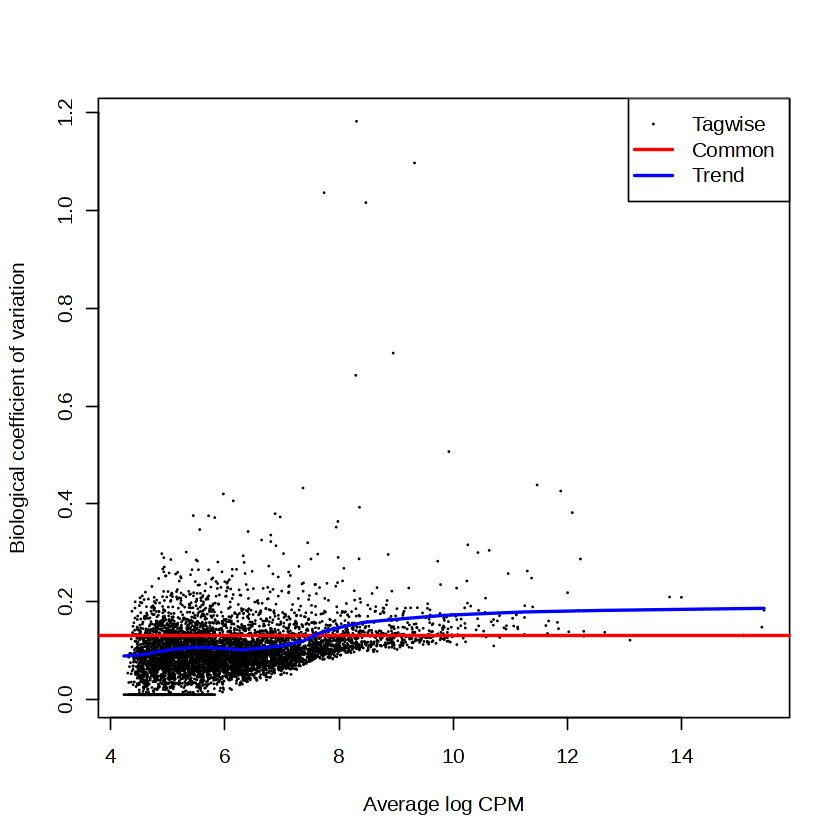

In [20]:
plotBCV(y)

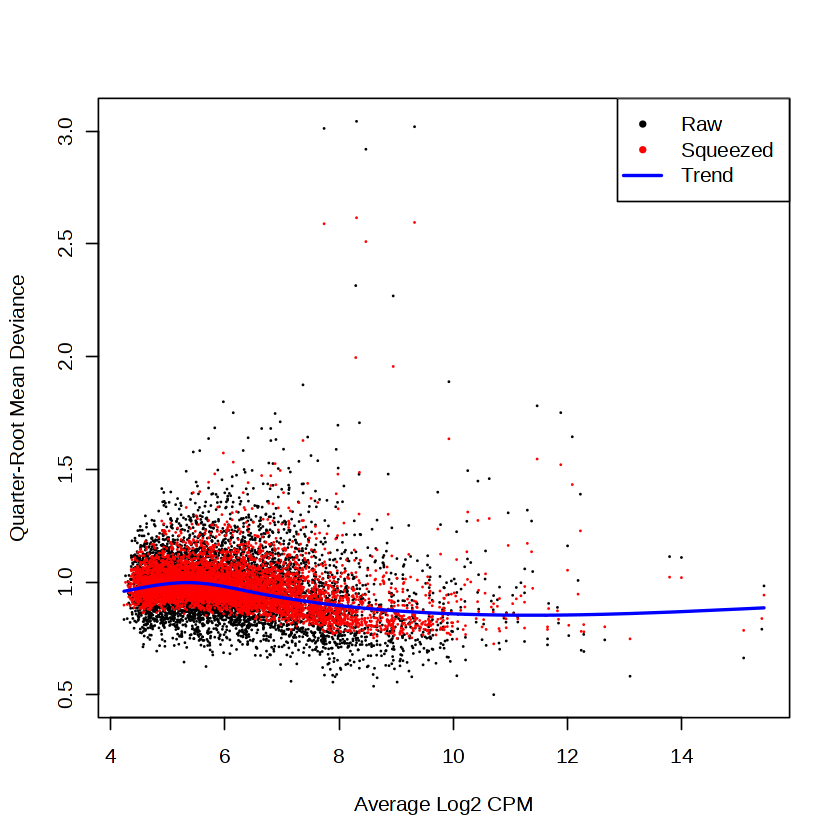

In [21]:
plotQLDisp(fit)

In [22]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Lm-PAMM1-Hrv135-1,Lm-PAMM1-Hrv135-2,Lm-PAMM1-Hrv135-3,Lm-PAMM1-Hrv136-1,Lm-PAMM1-Hrv136-2,Lm-PAMM1-Hrv136-3,Lm-PAMM1-Hrv236-1,Lm-PAMM1-Hrv236-2,Lm-PAMM1-Hrv236-3,UI-PAMM1-Hrv135-1,UI-PAMM1-Hrv135-2,UI-PAMM1-Hrv135-3,UI-PAMM1-Hrv136-1,UI-PAMM1-Hrv136-2,UI-PAMM1-Hrv136-3,UI-PAMM1-Hrv236-1,UI-PAMM1-Hrv236-2,UI-PAMM1-Hrv236-3
C15orf48,757.345643,697.97210,838.86249,731.49582,782.425993,959.08740,1422.89552,1430.16256,1258.91473,392.610793,373.920264,313.901050,229.512500,247.263210,241.663347,939.59009,837.71623,871.54071
STC1,82.483189,94.24096,65.69405,62.18768,46.135829,38.89835,74.95040,87.27370,69.86977,39.182714,51.830532,35.636109,27.230297,15.138564,24.166335,16.01574,31.06690,23.14932
C1orf56,3.749236,2.94503,10.10678,11.59431,6.590833,13.37131,102.83892,133.02201,105.11938,7.052888,5.923489,5.307506,7.780085,3.364125,4.264647,50.95917,41.42253,46.29864
MARCKS,941.058200,1060.21079,1101.63870,771.54890,705.219096,796.20057,1636.70751,1542.06997,1607.63411,782.870623,675.277784,800.675141,453.189937,359.961408,490.434439,1064.31873,1120.04349,1105.53656
TIMP1,3149.358121,2971.53525,2693.45608,2085.92251,1563.910439,2060.39690,1734.31733,1794.03759,1790.17675,1657.428796,1459.399685,1640.019252,787.733582,1015.965842,989.398172,1320.08525,1458.50919,1480.93098
SLC30A4,78.733953,58.90060,40.42711,47.43128,50.843566,93.59915,84.82758,102.75774,95.04806,23.509628,28.136574,21.230023,23.340254,8.410313,14.215491,55.81243,43.60267,50.05259
CCL5,247.449567,456.47965,212.24232,504.87968,542.331374,719.61945,227.17523,220.99953,256.18915,55.639454,61.456202,79.612585,108.921187,146.339451,248.771092,158.21610,167.87027,178.93801
SOD2,2684.452875,1940.77476,2516.58748,2908.06478,3037.432315,3830.27175,2706.92946,2564.01684,2471.87908,1235.039141,1268.367154,1311.712115,1367.349896,1544.133515,1785.465666,2304.81060,1838.94245,2209.82181
LDLRAD4,59.987774,41.23042,50.53389,53.75546,44.252734,40.11392,67.39726,69.67820,60.42791,120.682759,117.729351,116.006910,48.625530,92.513446,72.499004,92.21184,96.47090,120.75187
FPR3,52.489302,117.80120,85.90760,55.86351,39.544996,36.46720,23.82144,28.85663,23.28992,119.899104,125.874148,117.523340,85.580932,122.790574,110.880830,39.79669,47.96293,46.92430


In [23]:
summary(decideTests(qlf))

       summed_celltype$infectionLm
Down                           114
NotSig                        5817
Up                             157

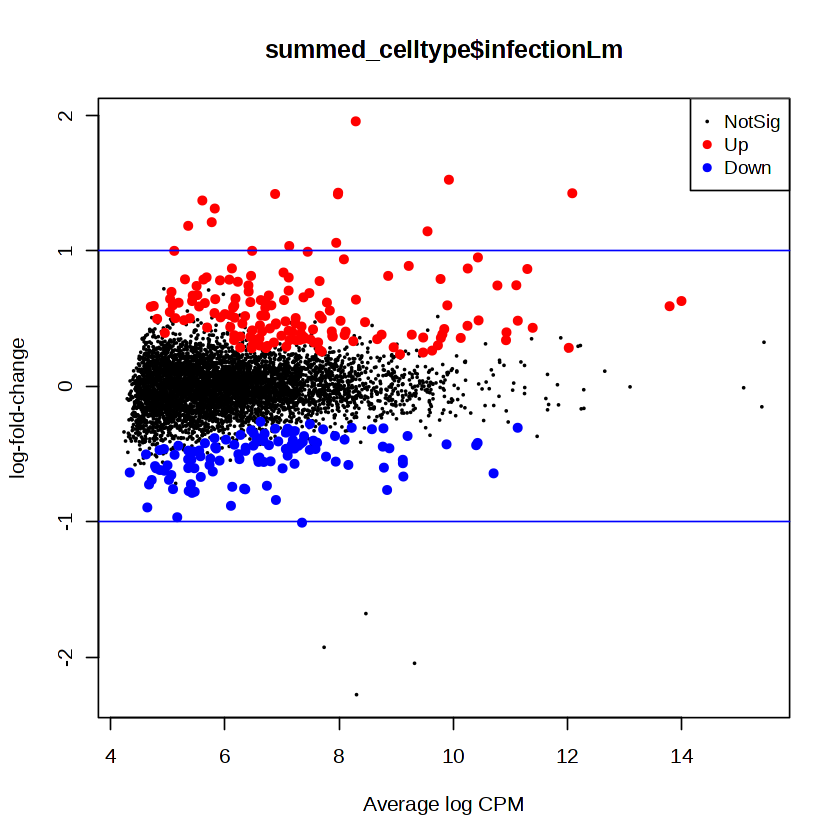

In [24]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

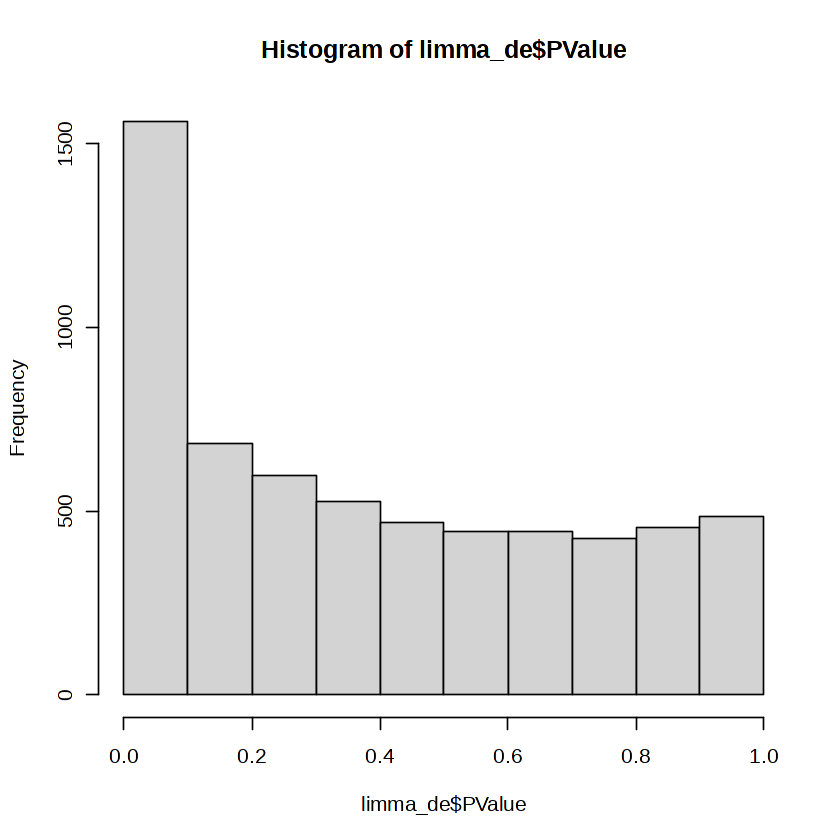

In [25]:
limma_de = qlf$table
limma_de$p.adjust = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

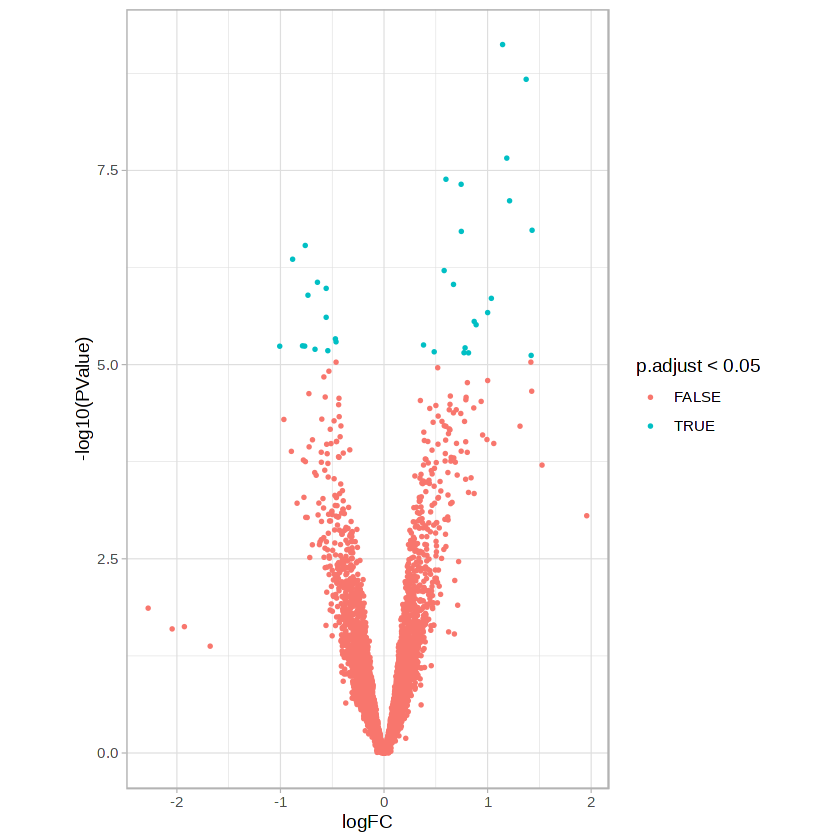

In [26]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = p.adjust < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

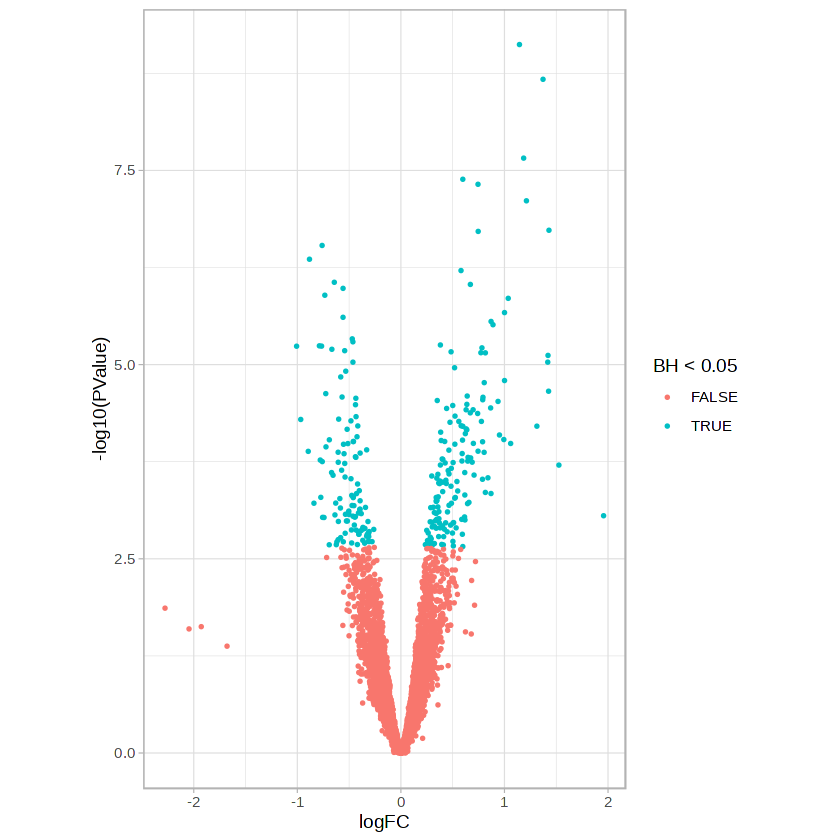

In [27]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
